In [45]:
#Import libraries
import pandas as pd
import geopandas as gpd
import re

In [46]:
#Data loading
df_aed = pd.read_parquet('aed_locations.parquet.gzip')


In [47]:
#DO WE NEED THIS?
#df_ambloc = pd.read_parquet('ambulance_locations.parquet.gzip')
#df_cad9= pd.read_parquet('cad9.parquet.gzip')
#df_intbxl = pd.read_parquet('interventions_bxl.parquet.gzip')
#df_intbxl2 = pd.read_parquet('interventions_bxl2.parquet.gzip')
#df_int1 = pd.read_parquet('interventions1.parquet.gzip')
#df_int2 = pd.read_parquet('interventions2.parquet.gzip')
#df_int3 = pd.read_parquet('interventions3.parquet.gzip')
#df_mug = pd.read_parquet('mug_locations.parquet.gzip')
#df_pit = pd.read_parquet('pit_locations.parquet.gzip')

In [48]:
#Data overview
df_aed.head()

,id,type,address,number,postal_code,municipality,province,location,public,available,hours
0,13.0,None,Blvd. Fr. Roosevelt,24.0,7060.0,SOIGNIES,Hainaut,None,Y,None,None
1,70.0,None,Ch. De Wégimont,76.0,4630.0,Ayeneux,Liège,None,None,None,None
2,71.0,None,Place Saint - Lambert,NaN,4020.0,Liège,Liège,None,None,None,None
3,72.0,None,Rue du Doyard,NaN,4990.0,Lierneux,Liège,None,None,None,None
4,73.0,None,Fond Saint Servais,NaN,4000.0,Liège,Liège,None,None,None,None


In [49]:
df_aed.describe

<bound method NDFrame.describe of             id                         type                address  number  \
0         13.0                         None    Blvd. Fr. Roosevelt    24.0   
1         70.0                         None        Ch. De Wégimont    76.0   
2         71.0                         None  Place Saint - Lambert     NaN   
3         72.0                         None          Rue du Doyard     NaN   
4         73.0                         None     Fond Saint Servais     NaN   
...        ...                          ...                    ...     ...   
15222  16662.0  Appareil fixe-Vast apparaat     Nekkerspoel-Borcht    19.0   
15223  16664.0  Appareil fixe-Vast apparaat          Nieuwe Dreef     17.0   
15224  16665.0  Appareil fixe-Vast apparaat     Panterschipstraat    207.0   
15225  16666.0  Appareil fixe-Vast apparaat    Albert Leemansplein    20.0   
15226  16668.0  Appareil fixe-Vast apparaat        rue Saint-Donat    18.0   

       postal_code municipali

In [50]:
def string_cleaning(df ,columnname, old_and_new_labels):
    repl = {'/': None,
        '.': None,
        '. ': None,
        ' ': None,
        ';': None
       }
    df =df.replace({columnname: repl})
    for key, input_list in old_and_new_labels.items():
        for word in input_list:
            df.loc[df[columnname].str.contains(word, na=False, case=False), columnname] = key
    return df


In [51]:
#Start of data cleaning for location/placement of AED

In [52]:
# Renaming locations into 3 categories for placement
renaming_locations = {'outside public acccess': ['Extérieur','buit','Façade', 'facade','gevel', 'straat', 'veld','rue','veranda','muur', 'pied',
                                   'voorkant','mur','parking','pont', 'chemin', 'parc','plein','strand','tuin','jardin','fit-o-meter', 'hoek',
                                   'haute tension', 'thv','t.h.v', 'Loods', 'Militar','Dépôt','depot','economaat','park','Schelde','terras','Bois','port',
                                   'cour','pierre','bus', 'terrain'], 
                      'inside access': ['Accueil', 'Acceuil','accueuil','inkom','ing','onth','recep','récep','balie','comptoir','entr',
                                    'garde','keet', 'secrétar', 'quichets','secretar', 'caisse', 'sorti', 'portier', 'lobby', 'lobie', 'foyer', 'gardien',
                                    'info','securi', 'chantier', 'koer 2','klantendienst','wacht','kassa', 'self', 'TIKKLOK', 'pointeuse','poort','accès', 
                                    'préau', 'rez', 'réz','glvl','Gelijkvloers','rdc','r.d.c', '0','geschoss', 'geijkvloers', 'einpfang'],
                      'inside less accessible': ['sous-sol','sous sol','1er', '1e', '°', 'etage', 'ètage','étage','étg' ,'3de', '2de', '4de', '2e','1ste', 
                                    'verd', 'niv', '18th', '5i','5e', 'quai', 'spoor', 'perron','club', 'dojo', 'petan','tennis','voetbal','fiets', 'sport', 
                                    'athlét', 'athlet', 'zwem', 'football', 'hockey','jeux', 'fitness','Atletiek','speel','speler','foot','ski','padel', 'récré', 'redder',
                                 'sauveteurs','natation','pattinoire', 'sal','ascenseur','ASCENCEUR', 'Escalier' ,'local','lokaal', 'caf', 'bure', 'hal', 'gang', 'buvette', 
                                 'vestia','zaal','couloir','binnen','réfectoire',
                                    'keuken', 'cuisine','biblio','bar','infirmerie', 'ruimte', 'secret','maga','ateli', 'garage','cantine', 'rentré',
                                    'kantine', 'sacristie', 'kantoor', 'production', 'kleedkamer', 'lift', 'Intérieur','bât', 'bat', 'bouw', 'house',
                                    'shop', 'station', 'piscine', 'werkplaats', 'vestaire', 'restaurant','tandarts','praktijk', 'kabinet', 'refter',
                                    'winkel', 'toilet', 'room','maison', 'sanitair', 'office', 'lab','kamer','deur', 'school', 'facult', 
                                    'gym', 'accomodat','ecole', 'école', 'kerk', 'bloc', 'blok', 'Collège','eglise','trap','aula','huis',
                                    'restauration','catering','wc','hangar', 'kazerne','kabine', 'casernes', 'terminal', 'kai','fabriek','flats',
                                    'pharma','complexe', 'hulppost', 'onder','afspraak', 'bellen', 'facility', 'loge', 'pavillon', 'toonbank',
                                    'Fours', 'Enseignement', 'JBC', 'Refectoire', 'imprimante','Kast','Uitpunt','auditoraat','administratif','Recycl',
                                    'photocop', 'usine','chateau','class','afd','galeri', 'cc ', 'kinderboerderij', 'babygroup', 'Geriaterie', 'cabinet',
                                    'hébergement','bassin','Ortho','neuro','SP Dienst','panoptique', 'mobi','nomade','dispatch','volant','portable', 
                                    'Brandweerwagen', 'wagen','pas de véhicule fixe', 'non fixé','pas véhicule fixe',
                                 'leen', 'bouillet', 'fond réfectaire', 'operateur four', 'kinderopvang MIKI', 'espace client', 'ouvriers', 
                                 'schuin over medische dienst', 'all-ranks', 'ancienne boulangerie', 'jeu de balle', 'anciennes papeteries', 'graaf jansdijk', 
                                 'nouvelle tribune', '"chant des oiseaux' 'brasserie tinto', 'du coté gauche,près des gradins' 'Jeu de balle', 'piece de vie', 'omkleedse', 
                                 'chiro jongens SSW', 'autorail', 'milka', 'service travaux', 'ensachage', 'tour', 'voie humide', 'oiseaux', 'piece de vie', 
                                 'boverie', 'service population', 'locaux sociaux', 'espace vital', 'OC Lauwe', 'ecluse', 'poste de commande', 'medic','préfecture', 
                                 'bornavie', 'usage professionnel','chariot', 'Flegado', 'expédition', 'CDC', 'DCU', 'magneet', 'play 2 move','supermarkt', 'testarea', 
                                 'roekhout', 'sellerie', 'espace public','Leie', 'laugh', 'stad', 'leveren locatie', 'TEn HOve', 'CBRN', 'Events', 'rochehaut', 
                                 'Munsterbilzen', 'brasserie', 'Buanderie','Premiers Soins','EHBO','camion','un sac','secours','reserve', 'Afrika', 'définier', 'rechange', 
                                 'vervangt','aucun', 'section', 'corner','preau', 'dessus lance d Incendie', 'commande poste', 'zone de titre éditable', 'poste de commandes',
                                 'sacoche', 'plaine des sapins', 'boulodrôme', 'péniche', 'stand de tir', 'pièce de confidentialité', 'zijde spaarbekken', 'untergeschassPlakettenaum', 
                                 'expéditions', 'coté gauche','sambre', 'Woluwe', 'Villers', 'au sein du site prod', 'site du CTA', 'oc de klakeye', '0', '1', '2', '3', '4', '5', '6',  ]
                      }


In [53]:

aed_cleaning={'location': renaming_locations}

In [54]:
#New dataframe: cleaned_aed as copy of df_aed
cleaned_aed = df_aed.copy()


#Apply string cleaning
for column, labels in aed_cleaning.items():
    cleaned_aed = string_cleaning(cleaned_aed, column, labels)

In [55]:
#fill missing values in the 'location' column with 'inside less accessible' considering it is the most conservative category choice 
cleaned_aed['location'] = cleaned_aed['location'].fillna('inside less accessible')

In [56]:
#check if all locations are cleaned in the 3 categories
cleaned_aed.loc[cleaned_aed['location'].isna()]

,id,type,address,number,postal_code,municipality,province,location,public,available,hours


In [57]:
#Verify changes and counts of each location type
#count locations before cleaning and categorizing
df_aed['location'].value_counts()

location
/                                     314
.                                     289
Accueil                               196
                                       89
INKOM                                  81
                                     ... 
rez,mur de droite à côté l accueil      1
1er étage-mur du couloir                1
local maître nageur                     1
palier 1er étage                        1
Site de Mettet - Magasin                1
Name: count, Length: 5732, dtype: int64

In [58]:
# count locations after cleaning and categorizing in the 3 categories
cleaned_aed['location'].value_counts()

location
inside less accessible    9726
inside access             3845
outside public acccess    1655
                             1
Name: count, dtype: int64

In [59]:
#Data cleaning done for locations/ placements of AED

In [60]:
# Display the first few rows to understand the structure
print(cleaned_aed.head())

# Display the columns in the dataset
print(cleaned_aed.columns)

     id  type                address  number  postal_code municipality  \
0  13.0  None    Blvd. Fr. Roosevelt    24.0       7060.0     SOIGNIES   
1  70.0  None        Ch. De Wégimont    76.0       4630.0      Ayeneux   
2  71.0  None  Place Saint - Lambert     NaN       4020.0        Liège   
3  72.0  None          Rue du Doyard     NaN       4990.0     Lierneux   
4  73.0  None     Fond Saint Servais     NaN       4000.0        Liège   

  province                location public available hours  
0  Hainaut  inside less accessible      Y      None  None  
1    Liège  inside less accessible   None      None  None  
2    Liège  inside less accessible   None      None  None  
3    Liège  inside less accessible   None      None  None  
4    Liège  inside less accessible   None      None  None  
Index(['id', 'type', 'address', 'number', 'postal_code', 'municipality',
       'province', 'location', 'public', 'available', 'hours'],
      dtype='object')


In [61]:
#Data cleaning for availablility: column available and hours

In [62]:

# Display unique items in the 'available' column
print("Unique values in 'available' column:")
print(cleaned_aed['available'].unique())

# Display frequency of each unique item in the 'available' column
print("\nValue counts in 'available' column:")
print(cleaned_aed['available'].value_counts(dropna=False))


Unique values in 'available' column:
[None 'Oui-Ja' 'Non-Nee' 'N' 'maandag, dinsdag, donderdag, vrijdag'
 'kantooruren' 'Pendant heures d ouverture du site'
 'tijdens de openingsuren' 'tijdens onze openingsuren, zie nr. 12'
 'tijdens de kantooruren' 'tijdens de kantooruren in de week'
 'Tijdens de kantooruren' 'Nee' 'Ja' 'Oui'
 'indien de site open is, volledig toegangkelijk'
 'Horaire d ouverture de la buvette' '8:00 - 17:00'
 'tijdens openinguren sportcentrum' '09u-12u en op aanvraag'
 '16u-23u tijdens opening sporthal' 'horaire d ouverture de la pharmacie'
 'de 5h00 à 25h00' '5h00 à 25h00' 'Pendant les heures de cours'
 '9.00 - 17.00' '09.00 - 17.00' 'Piscine en travaux pour l instant'
 'Heure de bureau en semaine' 'zie rooster' 'Heures de bureau '
 'Heures de bureau'
 '+/ 8x per jaar zal ik het toestel meenemen wanneer ik een EHBO post ga bemannen. '
 'selon heures d ouverture d Euro-Délices'
 'enkel tijdens de kantooruren (8 - 19u)' 'tijdens werkuren'
 'oui via interphone'
 'Acces

In [63]:
# Display unique items in the 'hours' column
print("\nUnique values in 'hours' column:")
print(cleaned_aed['hours'].unique())

# Display frequency of each unique item in the 'hours' column
print("\nValue counts in 'hours' column:")
print(cleaned_aed['hours'].value_counts(dropna=False))


Unique values in 'hours' column:
[None 'Lundi au vendredi de 6h à 21h30' 'lundi au vendredi de 9h à 18h'
 '8h00 - 17h00' 'nvt' 'Lu - ve : 8.30 - 20.30 / Sa : 8.30 - 12.00'
 'En fonction des horaires d occupation'
 'Accessible lors d une activité au Marius Staquet '
 'Accessible lors d une activité sur le Plaine de Neckere '
 'Accessible lors d une activité au stade'
 'Lundi 18h30–20h00 + Mardi 18h30–20h00 + Mercredi 16h30–18h00 et 18h30-20h00'
 'de 8h à 16h en période scolaire, et lorsque les locaux sont mis à disposition, loués ou en cas de festivités'
 '8h-16h en période scolaire et lors des occupations des locaux'
 '7h30-16h30 du lundi au vendredi et lorsque les salles des fêtes sont occupées'
 'Tijdens openingsuren kantine voetbal ' 'du lundi au samedi 9h00-17h30 '
 'Quand salle (60p max) ouverte' 'van 8 tot 16u'
 'werkdagen tussen 7u15 en 22u00' '07.30 - 18.00 hrs'
 'Op weekdagen tussen 6 en 16:30 uur.' '8h00-12h00 / 13h30-17h00'
 '08:00 - 16:30'
 'schooldagen: 6u30 - 8u30 en 15u

In [64]:
#Extract time information from columns available and hours and make a combined column = combined_info

def extract_time_info(row):
    available = str(row['available']).lower()
    hours = str(row['hours']).lower()

    # Combine available and hours columns for easier processing
    combined_info = f"{available} {hours}"
    return combined_info

# Apply the extract_time_info function to each row of the cleaned DataFrame
cleaned_aed['combined_info'] = cleaned_aed.apply(extract_time_info, axis=1)

# Regular expressions for extracting time and days
time_pattern = r'(\d{1,2}[:h]\d{2})'
day_pattern = r'(lundi|mardi|mercredi|jeudi|vendredi|samedi|dimanche|lu|ma|me|je|ve|sa|di|maandag|dinsdag|woensdag|donderdag|vrijdag|tem|lu - ve|ma - vrij|ma tem vrij|ma - do)'

In [65]:
# Extract opening and closing hours from combined_info


def extract_time_info_from_combined_info(combined_info):
    # Initialize opening_hour, closing_hour, and opening_days
    opening_hour, closing_hour, opening_days = None, None, None
    #Extract opening and closing hours
    times = re.findall(time_pattern, combined_info)
    #Extract days from combined_info
    days = re.findall(day_pattern, combined_info)
    
           
    # Replace French/Dutch days and patterns with English days
    day_mapping = { 'lu': 'monday', 'me': 'wednesday', 'je': 'thursday', 've': 'friday', 'sa': 'saturday', 'lundi': 'monday', 'mardi': 'tuesday', 'mercredi': 'wednesday', 'jeudi': 'thursday', 'vendredi': 'friday', 'samedi': 'saturday', 'dimanche': 'sunday', 'wo': 'wednesday', 'do': 'thursday', 'vrij': 'friday', 'za': 'saturday', 'zo' : 'sunday',
        'maandag': 'monday', 'dinsdag': 'tuesday', 'woensdag': 'wednesday', 'donderdag': 'thursday', 'vrijdag': 'friday'
    }
    # Handle specific patterns
    if 'lundi au samedi' in combined_info.lower():
        opening_days = 'monday,tuesday,wednesday,thursday,friday,saturday'
    elif 'lu - ve' in combined_info.lower() or 'lundi au vendredi' in combined_info.lower():
        opening_days = 'monday,tuesday,wednesday,thursday,friday'
    elif 'ma - vrij' in combined_info.lower() or 'ma tem vrij' in combined_info.lower():
        opening_days = 'monday,tuesday,wednesday,thursday,friday'
    elif 'ma - do' in combined_info.lower():
        opening_days = 'monday,tuesday,wednesday,thursday'
    else:
        # Map the days to English names using the day_mapping dictionary
        days = [day_mapping.get(day, day) for day in days if day in day_mapping]
        # Set opening_days to the list of days joined by commas
        opening_days = ','.join(days)

       
    # If two hours in the combined_info, put the first hour in opening hour and second in closing hour
    if len(times) == 2:
        opening_hour, closing_hour = times[0], times[1]
    
    # Return the extracted information
    return opening_hour, closing_hour, opening_days




In [66]:
# Apply the time extraction function to each row of the cleaned DataFrame
cleaned_aed['opening_hour'], cleaned_aed['closing_hour'], cleaned_aed['opening_days'] = zip(*cleaned_aed['combined_info'].apply(extract_time_info_from_combined_info))

# Display the cleaned DataFrame with the new columns for opening and closing hours
print(cleaned_aed.head())
print(cleaned_aed.columns)

     id  type                address  number  postal_code municipality  \
0  13.0  None    Blvd. Fr. Roosevelt    24.0       7060.0     SOIGNIES   
1  70.0  None        Ch. De Wégimont    76.0       4630.0      Ayeneux   
2  71.0  None  Place Saint - Lambert     NaN       4020.0        Liège   
3  72.0  None          Rue du Doyard     NaN       4990.0     Lierneux   
4  73.0  None     Fond Saint Servais     NaN       4000.0        Liège   

  province                location public available hours combined_info  \
0  Hainaut  inside less accessible      Y      None  None     none none   
1    Liège  inside less accessible   None      None  None     none none   
2    Liège  inside less accessible   None      None  None     none none   
3    Liège  inside less accessible   None      None  None     none none   
4    Liège  inside less accessible   None      None  None     none none   

  opening_hour closing_hour opening_days  
0         None         None               
1         None    

In [67]:
#Check if datacleaning for opening_hour, closing_hour and opening_days worked
# Filter rows where opening_hour, closing_hour and opening_days are not None
non_null_rows = cleaned_aed[(cleaned_aed['opening_days'].notnull())&(cleaned_aed['opening_hour'].notnull()) & (cleaned_aed['closing_hour'].notnull())]

# Display the filtered DataFrame
print(non_null_rows[['combined_info','opening_days','opening_hour','closing_hour']].head())

                                          combined_info  \
750                                non-nee 8h00 - 17h00   
2513  non-nee 7h30-16h30 du lundi au vendredi et lor...   
3177             non-nee du lundi au samedi 9h00-17h30    
6164                              non-nee 08:00 - 16:30   
9994  non-nee uniquement accessible durant les horai...   

                                           opening_days opening_hour  \
750                                                             8h00   
2513           monday,tuesday,wednesday,thursday,friday         7h30   
3177  monday,tuesday,wednesday,thursday,friday,saturday         9h00   
6164                                                           08:00   
9994                                          wednesday         8h00   

     closing_hour  
750         17h00  
2513        16h30  
3177        17h30  
6164        16:30  
9994        15h30  


In [68]:
#24h - open all day 

In [69]:
# Define function to check if 'combined_info' contains only '24' or '7' and no other numbers
def contains_only_24_or_7(text):
    numbers = re.findall(r'\d+', text)
    return all(num in {'24', '7'} for num in numbers)

In [70]:
# Print rows where 'combined_info' contains '24'
rows_with_24 = cleaned_aed[cleaned_aed['combined_info'].str.contains('24', case=False, na=False)]

In [71]:
# Filter to only include rows with '24' (and optionally '7'), but exclude rows with other numbers
mask_combined_24 = rows_with_24['combined_info'].apply(contains_only_24_or_7)

In [72]:
# Apply the filtered mask to update `opening_hour`, `closing_hour`, and `opening_days` only if they are NaN
cleaned_aed.loc[(mask_combined_24 & cleaned_aed['opening_hour'].isna()), 'opening_hour'] = '00:00'
cleaned_aed.loc[(mask_combined_24 & cleaned_aed['closing_hour'].isna()), 'closing_hour'] = '23:59'
cleaned_aed.loc[(mask_combined_24 & cleaned_aed['opening_days'].isna()), 'opening_days'] = 'Monday, Tuesday, Wednesday, Thursday, Friday, Saturday, Sunday'

In [73]:
# Apply the filtered mask to update `opening_hour`, `closing_hour`, and `opening_days`
cleaned_aed.loc[rows_with_24[mask_combined_24].index, 'opening_hour'] = '00:00'
cleaned_aed.loc[rows_with_24[mask_combined_24].index, 'closing_hour'] = '23:59'
cleaned_aed.loc[rows_with_24[mask_combined_24].index, 'opening_days'] = 'Monday, Tuesday, Wednesday, Thursday, Friday, Saturday, Sunday'

In [74]:
# Display the updated DataFrame
print("\nUpdated 'cleaned_aed' DataFrame:")
print(cleaned_aed[['combined_info', 'opening_days', 'opening_hour', 'closing_hour']].head(51))


Updated 'cleaned_aed' DataFrame:
   combined_info opening_days opening_hour closing_hour
0      none none                      None         None
1      none none                      None         None
2      none none                      None         None
3      none none                      None         None
4      none none                      None         None
5      none none                      None         None
6      none none                      None         None
7      none none                      None         None
8      none none                      None         None
9      none none                      None         None
10     none none                      None         None
11     none none                      None         None
12     none none                      None         None
13     none none                      None         None
14     none none                      None         None
15     none none                      None         None
16     none no

In [75]:
# Display the rows that were updated
updated_rows = cleaned_aed.loc[rows_with_24[mask_combined_24].index, ['combined_info', 'opening_days', 'opening_hour', 'closing_hour']]

print("\nRows where 'combined_info' contains '24' and were updated:")
print(updated_rows)


Rows where 'combined_info' contains '24' and were updated:
                                           combined_info  \
10251                                        oui-ja 24/7   
10252                                   oui-ja 24/24 7/7   
10253                                   oui-ja 24/24 7/7   
10262                                     oui-ja 24h/24h   
10263                                     oui-ja 24h/24h   
10264                                     oui-ja 24h/24h   
10265                                     oui-ja 24h/24h   
10286                                        oui-ja 24/7   
10320                                       oui-ja 24/24   
10324                                       oui-ja 24/24   
10350                                       oui-ja 24/24   
10351                                      oui-ja 24h/24   
10352                                      oui-ja 24h/24   
10358                                oui-ja 24/24 en 7/7   
10402                            oui-ja 

In [76]:
# Define the days of the week
days_of_week = ['monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday']

In [77]:
# Make 2 columns per day with opening_hour and closing_hour
for day in days_of_week:
    print(day)

monday
tuesday
wednesday
thursday
friday
saturday
sunday


In [78]:
# Make 2 columns per day with opening_hour and closing_hour
for day in days_of_week:
    print("Day:", day)
    # Extract opening and closing hours column names for the day
    opening_hour_col = f"{day}_opening_hour"
    closing_hour_col = f"{day}_closing_hour"
    
    print("Opening hour column:", opening_hour_col)
    print("Closing hour column:", closing_hour_col)
    
    # Create new columns for opening and closing hours
    cleaned_aed[opening_hour_col] = None
    cleaned_aed[closing_hour_col] = None

# Display the updated DataFrame structure
print(cleaned_aed.columns)

Day: monday
Opening hour column: monday_opening_hour
Closing hour column: monday_closing_hour
Day: tuesday
Opening hour column: tuesday_opening_hour
Closing hour column: tuesday_closing_hour
Day: wednesday
Opening hour column: wednesday_opening_hour
Closing hour column: wednesday_closing_hour
Day: thursday
Opening hour column: thursday_opening_hour
Closing hour column: thursday_closing_hour
Day: friday
Opening hour column: friday_opening_hour
Closing hour column: friday_closing_hour
Day: saturday
Opening hour column: saturday_opening_hour
Closing hour column: saturday_closing_hour
Day: sunday
Opening hour column: sunday_opening_hour
Closing hour column: sunday_closing_hour
Index(['id', 'type', 'address', 'number', 'postal_code', 'municipality',
       'province', 'location', 'public', 'available', 'hours', 'combined_info',
       'opening_hour', 'closing_hour', 'opening_days', 'monday_opening_hour',
       'monday_closing_hour', 'tuesday_opening_hour', 'tuesday_closing_hour',
       'w

In [79]:
# Iterate over each row in the DataFrame
for index,row in cleaned_aed.iterrows():
    # Extract opening and closing hours from the row
    opening_hour = cleaned_aed.at[index, 'opening_hour']
    closing_hour = cleaned_aed.at[index, 'closing_hour']
    opening_days = cleaned_aed.at[index, 'opening_days']
    
    # Split the opening_days string into a list of individual days
    days_list = opening_days.split(',')
    
    # Iterate over each day of the week
    for day in days_of_week:
        # Check if the current day is in the list of opening_days
        if day in days_list:
            # If the day is in the list, assign the opening and closing hours to the respective columns
            opening_hour_col = f"{day}_opening_hour"
            closing_hour_col = f"{day}_closing_hour"
            cleaned_aed.at[index, opening_hour_col] = opening_hour
            cleaned_aed.at[index, closing_hour_col] = closing_hour

# Display the updated DataFrame
print(cleaned_aed.head())

     id  type                address  number  postal_code municipality  \
0  13.0  None    Blvd. Fr. Roosevelt    24.0       7060.0     SOIGNIES   
1  70.0  None        Ch. De Wégimont    76.0       4630.0      Ayeneux   
2  71.0  None  Place Saint - Lambert     NaN       4020.0        Liège   
3  72.0  None          Rue du Doyard     NaN       4990.0     Lierneux   
4  73.0  None     Fond Saint Servais     NaN       4000.0        Liège   

  province                location public available  ...  \
0  Hainaut  inside less accessible      Y      None  ...   
1    Liège  inside less accessible   None      None  ...   
2    Liège  inside less accessible   None      None  ...   
3    Liège  inside less accessible   None      None  ...   
4    Liège  inside less accessible   None      None  ...   

  wednesday_opening_hour wednesday_closing_hour thursday_opening_hour  \
0                   None                   None                  None   
1                   None                   None 

In [80]:
non_empty_rows = cleaned_aed
# Filter the DataFrame to display only the rows where the selected columns are not empty




print(non_empty_rows_filtered)

              combined_info opening_hour closing_hour opening_days  \
0                 none none         None         None                
1                 none none         None         None                
2                 none none         None         None                
3                 none none         None         None                
4                 none none         None         None                
...                     ...          ...          ...          ...   
15222          non-nee none         None         None                
15223           oui-ja none         None         None                
15224          non-nee none         None         None                
15225          non-nee none         None         None                
15226  non-nee 8h00 à 17h00         8h00        17h00                

      monday_opening_hour tuesday_opening_hour wednesday_opening_hour  \
0                    None                 None                   None   
1            

In [81]:
# 61 rows who have more than 2 hours in the combined_info

In [82]:
# Function to extract times and handle problematic rows
def extract_time_info_from_combined_info(combined_info):
    times = re.findall(time_pattern, combined_info)
    days = re.findall(day_pattern, combined_info)
    time_info = {f'opening_hour_{i}': None for i in range(len(days))}
    time_info.update({f'closing_hour_{i}': None for i in range(len(days))})
    
    # Handle problematic rows with more than 2 hours
print(f"Number of problematic rows: {len(cleaned_aed[cleaned_aed['combined_info'].str.count(time_pattern).gt(2)])}")
problematic_rows = cleaned_aed[cleaned_aed['combined_info'].str.count(time_pattern).gt(2)]['combined_info'].tolist()
print("Rows with more than 2 hours in the combined column:")
probmem_rows_dict={}
for i, row in enumerate(problematic_rows):
    print(f"{i + 1}. {row}")  
    probmem_rows_dict[row]= ''

print(probmem_rows_dict)


Number of problematic rows: 61
Rows with more than 2 hours in the combined column:
1. non-nee lundi 18h30–20h00 + mardi 18h30–20h00 + mercredi 16h30–18h00 et 18h30-20h00
2. non-nee 8h00-12h00 / 13h30-17h00
3. pendant heures d ouverture du site de 07h30 à 15h45 du lundi au jeudi. de 07h30 à 15h00 le vendredi. fermé les we et jours fériés.
4. none lundi 12h30-19h, mardi au vendredi 8h30-12h30
5. non-nee 7h30- 15h45  , vendredi 7h30-15h00   lundi au vendredi 
6. non-nee 7h30 15h45 lundi-jeudi   7h30-15h 00 le vendredi 
7. non-nee lundi au jeudi de 7h30-15h45  vendredi 7h30-15h00
8. non-nee mardi 18h30 à 20h00; jeudi 18h30 à 20h; samedi 9h30 à 11h30
9. horaire d ouverture de la pharmacie lundi au vendredi : 8h30-19h00. samedi : 8h30-12h30.
10. non-nee entre 8h15 et 17h30  (sauf le vendredi 16h30)
11. non-nee de 8h30 à 12h30 et de 13h15 à 17h00 (du lundi au vendredi uniquement)
12. de 5h00 à 25h00 de 5h00 à 25h00
13. 5h00 à 25h00 5h00 à 25h00
14. non-nee winterperiode: 8h00 - 19h00, zomerpe

In [83]:
probmem_rows_dict['non-nee 8h00-12h00 / 13h30-17h00'] = {'monday_opening_hour': '8h00', 'monday_closing_hour': '17h00', 'tuesday_opening_hour': '8h00', 'tuesday_closing_hour': '17h00', 'wednesday_opening_hour': '8h00', 'wednesday_closing_hour': '17h00', 'thursday_opening_hour': '8h00', 'thursday_closing_hour': '17h00', 'friday_opening_hour': '8h00', 'friday_closing_hour': '17h00', 'saturday_opening_hour': '0h00', 'saturday_closing_hour': '0h00','sunday_opening_hour': '8h00', 'sunday_closing_hour': '17h00', }
probmem_rows_dict['non-nee lundi 18h30–20h00 + mardi 18h30–20h00 + mercredi 16h30–18h00 et 18h30-20h00'] = {'monday_opening_hour': '18h30', 'monday_closing_hour': '20h00', 'tuesday_opening_hour': '18h30', 'tuesday_closing_hour': '20h00', 'wednesday_opening_hour': '16h30', 'wednesday_closing_hour': '20h00', 'thursday_opening_hour': '00h00', 'thursday_closing_hour': '00h00', 'friday_opening_hour': '00h00', 'friday_closing_hour': '00h00', 'saturday_opening_hour': '00h00', 'saturday_closing_hour': '0h00','sunday_opening_hour': '00h00', 'sunday_closing_hour': '00h00', }
probmem_rows_dict['pendant heures d ouverture du site de 07h30 à 15h45 du lundi au jeudi. de 07h30 à 15h00 le vendredi. fermé les we et jours fériés.'] = {'monday_opening_hour': '07h30', 'monday_closing_hour': '15h45', 'tuesday_opening_hour': '07h30', 'tuesday_closing_hour': '15h45', 'wednesday_opening_hour': '07h30', 'wednesday_closing_hour': '15h45', 'thursday_opening_hour': '07h30', 'thursday_closing_hour': '15h45', 'friday_opening_hour': '07h30', 'friday_closing_hour': '15h00', 'saturday_opening_hour': '00h00', 'saturday_closing_hour': '0h00','sunday_opening_hour': '00h00', 'sunday_closing_hour': '00h00', }
probmem_rows_dict['none lundi 12h30-19h, mardi au vendredi 8h30-12h30'] = {'monday_opening_hour': '12h30', 'monday_closing_hour': '19h00', 'tuesday_opening_hour': '08h30', 'tuesday_closing_hour': '12h30', 'wednesday_opening_hour': '08h30', 'wednesday_closing_hour': '12h30', 'thursday_opening_hour': '08h30', 'thursday_closing_hour': '12h30', 'friday_opening_hour': '08h30', 'friday_closing_hour': '12h30', 'saturday_opening_hour': '00h00', 'saturday_closing_hour': '0h00','sunday_opening_hour': '00h00', 'sunday_closing_hour': '00h00', }
probmem_rows_dict['non-nee lundi au jeudi de 7h30-15h45  vendredi 7h30-15h00','non-nee 7h30- 15h45  , vendredi 7h30-15h00   lundi au vendredi', 'non-nee 7h30 15h45 lundi-jeudi   7h30-15h 00 le vendredi' ] = {'monday_opening_hour': '07h30', 'monday_closing_hour': '15h45', 'tuesday_opening_hour': '07h30', 'tuesday_closing_hour': '15h45', 'wednesday_opening_hour': '07h30', 'wednesday_closing_hour': '15h45', 'thursday_opening_hour': '07h30', 'thursday_closing_hour': '15h45', 'friday_opening_hour': '07h30', 'friday_closing_hour': '15h00', 'saturday_opening_hour': '00h00', 'saturday_closing_hour': '0h00','sunday_opening_hour': '00h00', 'sunday_closing_hour': '00h00', }
probmem_rows_dict['non-nee mardi 18h30 à 20h00; jeudi 18h30 à 20h; samedi 9h30 à 11h30'] = {'monday_opening_hour': '00h00', 'monday_closing_hour': '00h00', 'tuesday_opening_hour': '18h30', 'tuesday_closing_hour': '20h00', 'wednesday_opening_hour': '00h00', 'wednesday_closing_hour': '00h00', 'thursday_opening_hour': '18h30', 'thursday_closing_hour': '20h00', 'friday_opening_hour': '00h00', 'friday_closing_hour': '00h00', 'saturday_opening_hour': '09h30', 'saturday_closing_hour': '11h30','sunday_opening_hour': '00h00', 'sunday_closing_hour': '00h00', }
probmem_rows_dict['lundi au vendredi : 8h30-19h00. samedi : 8h30-12h30.'] = {'monday_opening_hour': '08h30', 'monday_closing_hour': '19h00', 'tuesday_opening_hour': '08h30', 'tuesday_closing_hour': '19h00', 'wednesday_opening_hour': '08h30', 'wednesday_closing_hour': '19h00', 'thursday_opening_hour': '08h30', 'thursday_closing_hour': '19h00', 'friday_opening_hour': '08h30', 'friday_closing_hour': '19h00', 'saturday_opening_hour': '08h30', 'saturday_closing_hour': '12h30','sunday_opening_hour': '00h00', 'sunday_closing_hour': '00h00', }
probmem_rows_dict['entre 8h15 et 17h30'] = {'monday_opening_hour': '08h15', 'monday_closing_hour': '17h30', 'tuesday_opening_hour': '08h15', 'tuesday_closing_hour': '17h30', 'wednesday_opening_hour': '08h15', 'wednesday_closing_hour': '17h30', 'thursday_opening_hour': '08h15', 'thursday_closing_hour': '17h30', 'friday_opening_hour': '08h15', 'friday_closing_hour': '16h30', 'saturday_opening_hour': '00h00', 'saturday_closing_hour': '0h00','sunday_opening_hour': '00h00', 'sunday_closing_hour': '00h00', }
probmem_rows_dict['non-nee de 8h30 à 12h30 et de 13h15 à 17h00 (du lundi au vendredi uniquement)'] = {'monday_opening_hour': '08h30', 'monday_closing_hour': '17h00', 'tuesday_opening_hour': '08h30', 'tuesday_closing_hour': '17h00', 'wednesday_opening_hour': '08h30', 'wednesday_closing_hour': '17h00', 'thursday_opening_hour': '08h30', 'thursday_closing_hour': '17h00', 'friday_opening_hour': '08h30', 'friday_closing_hour': '17h00', 'saturday_opening_hour': '00h00', 'saturday_closing_hour': '0h00','sunday_opening_hour': '00h00', 'sunday_closing_hour': '00h00', }
probmem_rows_dict['de 5h00 à 25h00 de 5h00 à 25h00', '5h00 à 25h00 5h00 à 25h00' ] = {'monday_opening_hour': '05h00', 'monday_closing_hour': '24h00', 'tuesday_opening_hour': '05h00', 'tuesday_closing_hour': '24h00', 'wednesday_opening_hour': '05h00', 'wednesday_closing_hour': '24h00', 'thursday_opening_hour': '05h00', 'thursday_closing_hour': '24h00', 'friday_opening_hour': '05h00', 'friday_closing_hour': '24h00', 'saturday_opening_hour': '05h00', 'saturday_closing_hour': '24h00','sunday_opening_hour': '05h00', 'sunday_closing_hour': '24h00', }
probmem_rows_dict['non-nee winterperiode: 8h00 - 19h00, zomerperiode: 8h00 - 21h00'] = {'monday_opening_hour': '08h00', 'monday_closing_hour': '19h00', 'tuesday_opening_hour': '08h00', 'tuesday_closing_hour': '19h00', 'wednesday_opening_hour': '08h00', 'wednesday_closing_hour': '19h00', 'thursday_opening_hour': '08h00', 'thursday_closing_hour': '19h00', 'friday_opening_hour': '08h00', 'friday_closing_hour': '19h00', 'saturday_opening_hour': '08h00', 'saturday_closing_hour': '19h00','sunday_opening_hour': '08h00', 'sunday_closing_hour': '19h00', }
probmem_rows_dict['non-nee tijdens onze openingsuren : 08:00-12:00 & 13:00-17:00 van maandag tot vrijdag'] = {'monday_opening_hour': '08h00', 'monday_closing_hour': '17h00', 'tuesday_opening_hour': '08h00', 'tuesday_closing_hour': '17h00', 'wednesday_opening_hour': '08h00', 'wednesday_closing_hour': '17h00', 'thursday_opening_hour': '08h00', 'thursday_closing_hour': '17h00', 'friday_opening_hour': '08h00', 'friday_closing_hour': '17h00', 'saturday_opening_hour': '00h00', 'saturday_closing_hour': '00h00','sunday_opening_hour': '00h00', 'sunday_closing_hour': '00h00', }
probmem_rows_dict['non-nee du lundi au vendredi : 08:30 -12h15 | 13h30 - 18h30 samedi : 08h30 - 12h15'] = {'monday_opening_hour': '08h00', 'monday_closing_hour': '18h30', 'tuesday_opening_hour': '08h00', 'tuesday_closing_hour': '18h30', 'wednesday_opening_hour': '08h00', 'wednesday_closing_hour': '18h30', 'thursday_opening_hour': '08h00', 'thursday_closing_hour': '18h30', 'friday_opening_hour': '08h00', 'friday_closing_hour': '18h30', 'saturday_opening_hour': '08h30', 'saturday_closing_hour': '12h15','sunday_opening_hour': '00h00', 'sunday_closing_hour': '00h00', }
probmem_rows_dict['non-nee du lundi au vendredi de 8h30 à 12h30 et de 13h30 à 16h, fermé le jeudi matin, fermé les samedis et dimanches et jours fériés'] = {'monday_opening_hour': '08h30', 'monday_closing_hour': '16h00', 'tuesday_opening_hour': '08h30', 'tuesday_closing_hour': '16h00', 'wednesday_opening_hour': '08h30', 'wednesday_closing_hour': '16h00', 'thursday_opening_hour': '13h00', 'thursday_closing_hour': '16h00', 'friday_opening_hour': '08h30', 'friday_closing_hour': '16h00', 'saturday_opening_hour': '00h00', 'saturday_closing_hour': '00h00','sunday_opening_hour': '00h00', 'sunday_closing_hour': '00h00', }
probmem_rows_dict['de 5h30 à 21h30 de 5h30 à 21h30'] = {'monday_opening_hour': '05h30', 'monday_closing_hour': '21h30', 'tuesday_opening_hour': '05h30', 'tuesday_closing_hour': '21h30', 'wednesday_opening_hour': '05h30', 'wednesday_closing_hour': '21h30', 'thursday_opening_hour': '05h30', 'thursday_closing_hour': '21h30', 'friday_opening_hour': '05h30', 'friday_closing_hour': '21h30', 'saturday_opening_hour': '05h30', 'saturday_closing_hour': '21h30','sunday_opening_hour': '05h30', 'sunday_closing_hour': '21h30', }
probmem_rows_dict['non-nee ma-do 07h00-16h30  vr 07h00-14h30   weekend gesloten'] = {'monday_opening_hour': '07h00', 'monday_closing_hour': '16h30', 'tuesday_opening_hour': '07h000', 'tuesday_closing_hour': '16h30', 'wednesday_opening_hour': '07h00', 'wednesday_closing_hour': '16h30', 'thursday_opening_hour': '07h00', 'thursday_closing_hour': '16h30', 'friday_opening_hour': '07h00', 'friday_closing_hour': '14h30', 'saturday_opening_hour': '00h00', 'saturday_closing_hour': '0h00','sunday_opening_hour': '00h00', 'sunday_closing_hour': '00h00', }
probmem_rows_dict['non-nee du lundi au jeudi, de 7h00 à 17h00 / vendredi de 7h00 à 16h00'] = {'monday_opening_hour': '07h00', 'monday_closing_hour': '17h00', 'tuesday_opening_hour': '07h00', 'tuesday_closing_hour': '17h00', 'wednesday_opening_hour': '07h00', 'wednesday_closing_hour': '17h00', 'thursday_opening_hour': '07h00', 'thursday_closing_hour': '17h00', 'friday_opening_hour': '07h00', 'friday_closing_hour': '16h00', 'saturday_opening_hour': '00h00', 'saturday_closing_hour': '0h00','sunday_opening_hour': '00h00', 'sunday_closing_hour': '00h00', }
probmem_rows_dict['non-nee 7h25-15h55/lun-jeu - 7h25-13h55/ven'] = {'monday_opening_hour': '7h250', 'monday_closing_hour': '15h55', 'tuesday_opening_hour': '7h25', 'tuesday_closing_hour': '15h55', 'wednesday_opening_hour': '07h25', 'wednesday_closing_hour': '15h55', 'thursday_opening_hour': '7h25', 'thursday_closing_hour': '15h55', 'friday_opening_hour': '7h25', 'friday_closing_hour': '13h55', 'saturday_opening_hour': '00h00', 'saturday_closing_hour': '0h00','sunday_opening_hour': '00h00', 'sunday_closing_hour': '00h00', }
probmem_rows_dict['du lundi au jeudi, de 7h30 à 17h00 / vendredi de 7h30 à 16h00 / samedi de 8h30 à 12h30'] = {'monday_opening_hour': '7h30', 'monday_closing_hour': '17h00', 'tuesday_opening_hour': '7h30', 'tuesday_closing_hour': '17h00', 'wednesday_opening_hour': '7h30', 'wednesday_closing_hour': '17h00', 'thursday_opening_hour': '7h30', 'thursday_closing_hour': '17h00', 'friday_opening_hour': '7h30', 'friday_closing_hour': '16h00', 'saturday_opening_hour': '8h30', 'saturday_closing_hour': '12h30','sunday_opening_hour': '00h00', 'sunday_closing_hour': '00h00', }
probmem_rows_dict['du lundi au jeudi, de 7h30 à 16h30 / vendredi de 7h30 à 16h00'] = {'monday_opening_hour': '7h30', 'monday_closing_hour': '16h30', 'tuesday_opening_hour': '7h30', 'tuesday_closing_hour': '16h30', 'wednesday_opening_hour': '7h30', 'wednesday_closing_hour': '16h30', 'thursday_opening_hour': '7h30', 'thursday_closing_hour': '16h30', 'friday_opening_hour': '7h30', 'friday_closing_hour': '16h00', 'saturday_opening_hour': '00h00', 'saturday_closing_hour': '00h00','sunday_opening_hour': '00h00', 'sunday_closing_hour': '00h00', }
probmem_rows_dict['du lundi au jeudi, de 7h30 à 16h45 / vendredi de 7h30 à 16h00 / samedi de 8h30 à 12h30'] = {'monday_opening_hour': '7h30', 'monday_closing_hour': '16h45', 'tuesday_opening_hour': '7h30', 'tuesday_closing_hour': '16h45', 'wednesday_opening_hour': '7h30', 'wednesday_closing_hour': '16h45', 'thursday_opening_hour': '7h30', 'thursday_closing_hour': '16h45', 'friday_opening_hour': '7h30', 'friday_closing_hour': '16h00', 'saturday_opening_hour': '8h30', 'saturday_closing_hour': '12h30','sunday_opening_hour': '00h00', 'sunday_closing_hour': '00h00', }
probmem_rows_dict['07h30-21h30 du lundi au vendredi, de 08h00 à 18h le samedi'] = {'monday_opening_hour': '7h30', 'monday_closing_hour': '21h30', 'tuesday_opening_hour': '7h30', 'tuesday_closing_hour': '21h30', 'wednesday_opening_hour': '7h30', 'wednesday_closing_hour': '21h30', 'thursday_opening_hour': '7h30', 'thursday_closing_hour': '21h30', 'friday_opening_hour': '7h30', 'friday_closing_hour': '21h30', 'saturday_opening_hour': '8h00', 'saturday_closing_hour': '18h00','sunday_opening_hour': '00h00', 'sunday_closing_hour': '00h00', }
probmem_rows_dict['ma- vrij : 8:00 - 17:00  za en zo: 13:00 - 17:00'] = {'monday_opening_hour': '08h00', 'monday_closing_hour': '17:00', 'tuesday_opening_hour': '08h00', 'tuesday_closing_hour': '17:00', 'wednesday_opening_hour': '08h00', 'wednesday_closing_hour': '17:00', 'thursday_opening_hour': '08h00', 'thursday_closing_hour': '17:00', 'friday_opening_hour': '08h00', 'friday_closing_hour': '17:00', 'saturday_opening_hour': '13h00', 'saturday_closing_hour': '17h00','sunday_opening_hour': '13h00', 'sunday_closing_hour': '17h00', }
probmem_rows_dict['ma-do: 8:00-16:30; vrijdag: 8:00 - 15:00'] = {'monday_opening_hour': '08h00', 'monday_closing_hour': '16h30', 'tuesday_opening_hour': '08h00', 'tuesday_closing_hour': '16:30', 'wednesday_opening_hour': '08h00', 'wednesday_closing_hour': '16:30', 'thursday_opening_hour': '08h00', 'thursday_closing_hour': '16:30', 'friday_opening_hour': '08h00', 'friday_closing_hour': '15h00', 'saturday_opening_hour': '00h00', 'saturday_closing_hour': '00h00','sunday_opening_hour': '00h00', 'sunday_closing_hour': '00h00', }
probmem_rows_dict['lu, ma, jeu, ve : 08h00-17h00 ; me : 08h00-16h00'] = {'monday_opening_hour': '08h00', 'monday_closing_hour': '17h00', 'tuesday_opening_hour': '08h00', 'tuesday_closing_hour': '17h00', 'wednesday_opening_hour': '08h00', 'wednesday_closing_hour': '16h00', 'thursday_opening_hour': '08h00', 'thursday_closing_hour': '17h00', 'friday_opening_hour': '08h00', 'friday_closing_hour': '17h00', 'saturday_opening_hour': '00h00', 'saturday_closing_hour': '00h00','sunday_opening_hour': '00h00', 'sunday_closing_hour': '00h00', }
probmem_rows_dict['ma - do 08:00-12:00 / 13:00 - 17:00 - vrijdag 08:00-12:00 / 13:00-16:00'] = {'monday_opening_hour': '08h00', 'monday_closing_hour': '17h00', 'tuesday_opening_hour': '08h00', 'tuesday_closing_hour': '17h00', 'wednesday_opening_hour': '08h00', 'wednesday_closing_hour': '17h00', 'thursday_opening_hour': '08h00', 'thursday_closing_hour': '17h00', 'friday_opening_hour': '08h00', 'friday_closing_hour': '16h00', 'saturday_opening_hour': '00h00', 'saturday_closing_hour': '00h00','sunday_opening_hour': '00h00', 'sunday_closing_hour': '00h00', }
probmem_rows_dict['werkdagen van 08:00 tot 16:30 (vrijdag tot 15:00)'] = {'monday_opening_hour': '08h00', 'monday_closing_hour': '16h30', 'tuesday_opening_hour': '08h00', 'tuesday_closing_hour': '16h30', 'wednesday_opening_hour': '08h00', 'wednesday_closing_hour': '16h30', 'thursday_opening_hour': '08h00', 'thursday_closing_hour': '16h30', 'friday_opening_hour': '08h00', 'friday_closing_hour': '15h00', 'saturday_opening_hour': '00h00', 'saturday_closing_hour': '00h00','sunday_opening_hour': '00h00', 'sunday_closing_hour': '00h00', }
probmem_rows_dict['du lundi au jeudi, de 8h00 à 16h30 / vendredi de 8h00 à 15h30)'] = {'monday_opening_hour': '08h00', 'monday_closing_hour': '16h30', 'tuesday_opening_hour': '08h00', 'tuesday_closing_hour': '16h30', 'wednesday_opening_hour': '08h00', 'wednesday_closing_hour': '16h30', 'thursday_opening_hour': '08h00', 'thursday_closing_hour': '16h30', 'friday_opening_hour': '08h00', 'friday_closing_hour': '15h30', 'saturday_opening_hour': '00h00', 'saturday_closing_hour': '00h00','sunday_opening_hour': '00h00', 'sunday_closing_hour': '00h00', }
probmem_rows_dict['du lundi au jeudi entre 8h00 et 18h00 et le vendredi entre 08h00 et 16h00.'] = {'monday_opening_hour': '08h00', 'monday_closing_hour': '18h00', 'tuesday_opening_hour': '08h00', 'tuesday_closing_hour': '18h00', 'wednesday_opening_hour': '08h00', 'wednesday_closing_hour': '18h00', 'thursday_opening_hour': '08h00', 'thursday_closing_hour': '18h00', 'friday_opening_hour': '08h00', 'friday_closing_hour': '16h00', 'saturday_opening_hour': '00h00', 'saturday_closing_hour': '00h00','sunday_opening_hour': '00h00', 'sunday_closing_hour': '00h00', }
probmem_rows_dict['lundi au jeudi de 8h00 à 19h30  et le vendredi de 8h00 à 15h30'] = {'monday_opening_hour': '08h00', 'monday_closing_hour': '19h30', 'tuesday_opening_hour': '08h00', 'tuesday_closing_hour': '19h30', 'wednesday_opening_hour': '08h00', 'wednesday_closing_hour': '19h30', 'thursday_opening_hour': '08h00', 'thursday_closing_hour': '19h30', 'friday_opening_hour': '08h00', 'friday_closing_hour': '15h30', 'saturday_opening_hour': '00h00', 'saturday_closing_hour': '00h00','sunday_opening_hour': '00h00', 'sunday_closing_hour': '00h00', }
probmem_rows_dict['8h25 à 16h25 du lundi au vendredi sauf le mercredi de 8h25 à 12h', 'du lundi au vendredi de 8h25 à 16h25 sauf le mercredi de 8h25 à 12h'] = {'monday_opening_hour': '08h25', 'monday_closing_hour': '16h25', 'tuesday_opening_hour': '08h25', 'tuesday_closing_hour': '16h25', 'wednesday_opening_hour': '08h25', 'wednesday_closing_hour': '12h00', 'thursday_opening_hour': '08h25', 'thursday_closing_hour': '16h25', 'friday_opening_hour': '08h25', 'friday_closing_hour': '16h25', 'saturday_opening_hour': '00h00', 'saturday_closing_hour': '00h00','sunday_opening_hour': '00h00', 'sunday_closing_hour': '00h00', }
probmem_rows_dict['maandag t/m donderdag, 8:30 tot 17:00 / vrijdag 7:00 tot 16:30'] = {'monday_opening_hour': '08h30', 'monday_closing_hour': '17h00', 'tuesday_opening_hour': '08h30', 'tuesday_closing_hour': '17h00', 'wednesday_opening_hour': '08h30', 'wednesday_closing_hour': '17h00', 'thursday_opening_hour': '08h30', 'thursday_closing_hour': '17h00', 'friday_opening_hour': '07h00', 'friday_closing_hour': '16h30', 'saturday_opening_hour': '00h00', 'saturday_closing_hour': '00h00','sunday_opening_hour': '00h00', 'sunday_closing_hour': '00h00', }
probmem_rows_dict['du lundi au jeudi, de 8h30 à 16h45 / vendredi de 8h30 à 16h00'] = {'monday_opening_hour': '08h30', 'monday_closing_hour': '16h45', 'tuesday_opening_hour': '08h30', 'tuesday_closing_hour': '16h45', 'wednesday_opening_hour': '08h30', 'wednesday_closing_hour': '16h45', 'thursday_opening_hour': '08h30', 'thursday_closing_hour': '16h45', 'friday_opening_hour': '08h30', 'friday_closing_hour': '16h00', 'saturday_opening_hour': '00h00', 'saturday_closing_hour': '00h00','sunday_opening_hour': '00h00', 'sunday_closing_hour': '00h00', }
probmem_rows_dict['maandag - zaterdag van 8:30 tot 22:30 (soms 23:30). zondag 9:00 tot 18:00.'] = {'monday_opening_hour': '08h30', 'monday_closing_hour': '22h30', 'tuesday_opening_hour': '08h30', 'tuesday_closing_hour': '22h30', 'wednesday_opening_hour': '08h30', 'wednesday_closing_hour': '22h30', 'thursday_opening_hour': '08h30', 'thursday_closing_hour': '22h30', 'friday_opening_hour': '08h30', 'friday_closing_hour': '22h300', 'saturday_opening_hour': '08h30', 'saturday_closing_hour': '22h30','sunday_opening_hour': '09h00', 'sunday_closing_hour': '18h00', }
probmem_rows_dict['08h30 à12h30 et 13h30 à 16h30 lundi au vendredi'] = {'monday_opening_hour': '08h30', 'monday_closing_hour': '16h30', 'tuesday_opening_hour': '08h30', 'tuesday_closing_hour': '16h30', 'wednesday_opening_hour': '08h30', 'wednesday_closing_hour': '16h30', 'thursday_opening_hour': '08h30', 'thursday_closing_hour': '16h30', 'friday_opening_hour': '08h30', 'friday_closing_hour': '16h30', 'saturday_opening_hour': '00h00', 'saturday_closing_hour': '00h00','sunday_opening_hour': '00h00', 'sunday_closing_hour': '00h00', }
probmem_rows_dict['8h30-12h30 / 13h30-18h30'] = {'monday_opening_hour': '08h30', 'monday_closing_hour': '18h30', 'tuesday_opening_hour': '08h30', 'tuesday_closing_hour': '18h30', 'wednesday_opening_hour': '08h30', 'wednesday_closing_hour': '18h30', 'thursday_opening_hour': '08h30', 'thursday_closing_hour': '18h30', 'friday_opening_hour': '08h30', 'friday_closing_hour': '18h30', 'saturday_opening_hour': '00h00', 'saturday_closing_hour': '00h00','sunday_opening_hour': '00h00', 'sunday_closing_hour': '00h00', }
probmem_rows_dict['de 9h00 à 11h59 et de 14h00 à 15h59 du lundi au vendredi, fermé au public le jeudi matin, fermée les samedis, dimanches et jours férié '] = {'monday_opening_hour': '09h00', 'monday_closing_hour': '16h00', 'tuesday_opening_hour': '09h00', 'tuesday_closing_hour': '16h00', 'wednesday_opening_hour': '09h00', 'wednesday_closing_hour': '16h00', 'thursday_opening_hour': '13h00', 'thursday_closing_hour': '16h00', 'friday_opening_hour': '09h00', 'friday_closing_hour': '16h00', 'saturday_opening_hour': '00h00', 'saturday_closing_hour': '00h00','sunday_opening_hour': '00h00', 'sunday_closing_hour': '00h00', }
probmem_rows_dict['9h30 à 12h30 et de 13h30 à 17h du lundi au vendredi'] = {'monday_opening_hour': '09h30', 'monday_closing_hour': '17h00', 'tuesday_opening_hour': '09h30', 'tuesday_closing_hour': '17h00', 'wednesday_opening_hour': '09h30', 'wednesday_closing_hour': '17h00', 'thursday_opening_hour': '09h30', 'thursday_closing_hour': '17h00', 'friday_opening_hour': '09h30', 'friday_closing_hour': '17h00', 'saturday_opening_hour': '00h00', 'saturday_closing_hour': '00h00','sunday_opening_hour': '00h00', 'sunday_closing_hour': '00h00', }
probmem_rows_dict['du lundi au vendredi de 10h00 à 18h00 / du samedi au dimanche de 14h00 à 18h00'] = {'monday_opening_hour': '10h00', 'monday_closing_hour': '18h00', 'tuesday_opening_hour': '10h00', 'tuesday_closing_hour': '18h00', 'wednesday_opening_hour': '10h00', 'wednesday_closing_hour': '18h00', 'thursday_opening_hour': '10h00', 'thursday_closing_hour': '18h00', 'friday_opening_hour': '10h00', 'friday_closing_hour': '18h00', 'saturday_opening_hour': '14h00', 'saturday_closing_hour': '18h00','sunday_opening_hour': '14h00', 'sunday_closing_hour': '18h00', }
probmem_rows_dict['mi-juin et mi-septembre: 10h00-19h00; mi-septembre et mi-juin: 9h00 à 16h30'] = {'monday_opening_hour': '10h00', 'monday_closing_hour': '16h30', 'tuesday_opening_hour': '10h00', 'tuesday_closing_hour': '16h30', 'wednesday_opening_hour': '10h00', 'wednesday_closing_hour': '16h30', 'thursday_opening_hour': '10h00', 'thursday_closing_hour': '16h30', 'friday_opening_hour': '10h00', 'friday_closing_hour': '16h30', 'saturday_opening_hour': '00h00', 'saturday_closing_hour': '00h00','sunday_opening_hour': '00h00', 'sunday_closing_hour': '00h00', }
probmem_rows_dict['hiver : du lundi au vendredi de 06h30 à 17h00 et le samedi de 07h00 à 15h00'] = {'monday_opening_hour': '06h30', 'monday_closing_hour': '17h00', 'tuesday_opening_hour': '06h30', 'tuesday_closing_hour': '17h00', 'wednesday_opening_hour': '06h30', 'wednesday_closing_hour': '17h00', 'thursday_opening_hour': '06h30', 'thursday_closing_hour': '17h00', 'friday_opening_hour': '06h30', 'friday_closing_hour': '17h00', 'saturday_opening_hour': '07h00', 'saturday_closing_hour': '15h00','sunday_opening_hour': '00h00', 'sunday_closing_hour': '00h00', }

print(probmem_rows_dict)

{'non-nee lundi 18h30–20h00 + mardi 18h30–20h00 + mercredi 16h30–18h00 et 18h30-20h00': {'monday_opening_hour': '18h30', 'monday_closing_hour': '20h00', 'tuesday_opening_hour': '18h30', 'tuesday_closing_hour': '20h00', 'wednesday_opening_hour': '16h30', 'wednesday_closing_hour': '20h00', 'thursday_opening_hour': '00h00', 'thursday_closing_hour': '00h00', 'friday_opening_hour': '00h00', 'friday_closing_hour': '00h00', 'saturday_opening_hour': '00h00', 'saturday_closing_hour': '0h00', 'sunday_opening_hour': '00h00', 'sunday_closing_hour': '00h00'}, 'non-nee 8h00-12h00 / 13h30-17h00': {'monday_opening_hour': '8h00', 'monday_closing_hour': '17h00', 'tuesday_opening_hour': '8h00', 'tuesday_closing_hour': '17h00', 'wednesday_opening_hour': '8h00', 'wednesday_closing_hour': '17h00', 'thursday_opening_hour': '8h00', 'thursday_closing_hour': '17h00', 'friday_opening_hour': '8h00', 'friday_closing_hour': '17h00', 'saturday_opening_hour': '0h00', 'saturday_closing_hour': '0h00', 'sunday_opening_h

In [84]:
# How can I now see that the library above is working???????????

Rows that still need to be cleaned:


In [85]:
#If information about opening days and hours are missing

In [86]:
#Filter and handling missing data: when opening hours are missing than assign opening_hours and opening_days 
# If in missing data AND in outside_acces than assign opening_hours: 00h00 -24h00


# If in missing data AND in inside (insdide = inside access + inside less accessible), than look in location for sports (zie kladblok) than assign: 9h - 21h


# If in missing data AND in inside (insdide = inside access + inside less accessible), than look in location for school or office than assign: 9h - 17h


# If in missing data AND NOT in outside_access or (inside - sport) or (inside - school - office) than assign office hours: 9h-17h


# Filter out rows with None values in both available and hours columns to create the missing data DataFrame
#missing_data_hoursavailable = cleaned_aed[(cleaned_aed['available'].isna()) & (cleaned_aed['hours'].isna())]

# Create a DataFrame without the missing data
#data_without_missing = cleaned_aed.drop(missing_data_hoursavailable.index)

# Display the first 20 rows of the DataFrame without the missing data
#print(data_without_missing[['available', 'hours', 'opening_hour', 'closing_hour', 'opening_days']].head(10))


In [87]:
cleaned_aed

,id,type,address,number,postal_code,municipality,province,location,public,available,...,wednesday_opening_hour,wednesday_closing_hour,thursday_opening_hour,thursday_closing_hour,friday_opening_hour,friday_closing_hour,saturday_opening_hour,saturday_closing_hour,sunday_opening_hour,sunday_closing_hour
0,13.0,None,Blvd. Fr. Roosevelt,24.0,7060.0,SOIGNIES,Hainaut,inside less accessible,Y,None,...,None,None,None,None,None,None,None,None,None,None
1,70.0,None,Ch. De Wégimont,76.0,4630.0,Ayeneux,Liège,inside less accessible,None,None,...,None,None,None,None,None,None,None,None,None,None
2,71.0,None,Place Saint - Lambert,NaN,4020.0,Liège,Liège,inside less accessible,None,None,...,None,None,None,None,None,None,None,None,None,None
3,72.0,None,Rue du Doyard,NaN,4990.0,Lierneux,Liège,inside less accessible,None,None,...,None,None,None,None,None,None,None,None,None,None
4,73.0,None,Fond Saint Servais,NaN,4000.0,Liège,Liège,inside less accessible,None,None,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15222,16662.0,Appareil fixe-Vast apparaat,Nekkerspoel-Borcht,19.0,2800.0,Mechelen,Antwerpen,inside less accessible,Non-Nee,Non-Nee,...,None,None,None,None,None,None,None,None,None,None
15223,16664.0,Appareil fixe-Vast apparaat,Nieuwe Dreef,17.0,9160.0,Lokeren,Oost-Vlaanderen,inside access,Oui-Ja,Oui-Ja,...,None,None,None,None,None,None,None,None,None,None
15224,16665.0,Appareil fixe-Vast apparaat,Panterschipstraat,207.0,9000.0,Gent,Oost-Vlaanderen,inside less accessible,Oui-Ja,Non-Nee,...,None,None,None,None,None,None,None,None,None,None
15225,16666.0,Appareil fixe-Vast apparaat,Albert Leemansplein,20.0,1050.0,Bruxelles,Bruxelles-Brussel,inside less accessible,Oui-Ja,Non-Nee,...,None,None,None,None,None,None,None,None,None,None


In [88]:
cleaned_aed.loc[df_aed['opening_days']=='ma']

KeyError: 'opening_days'

In [ ]:
#DO WE NEED THIS?

In [ ]:
#standardize and clean the type column
#make the type binary, clean language differences
repl = {'Appareil fixe-Vast apparaat': 'fixed',
       'Appareil fixe': 'fixed',
       'Appareil Fixe': 'fixed',
       'Appareil Mobile- Mobiel apparaat': 'mobile',
       'Vast apparaat' : 'fixed'}

df_aed = df_aed.replace({'type': repl})

In [ ]:
# NOT SURE WHAT WE NEED FROM THIS PART

In [ ]:
df_aed['postal_code'].isna().value_counts()


postal_code
False    15193
True        34
Name: count, dtype: int64

In [ ]:
#Missing data
#Missing values for postal code and municipality (identify them as Nan)
a = df_aed.loc[df_aed['postal_code'].isna()& df_aed['municipality'].isna()]
b = df_aed.loc[df_aed['postal_code'].isna()] 


In [ ]:
a

,id,type,address,number,postal_code,municipality,province,location,public,available,hours,opening_hour,closing_hour,opening_days
174,507.0,None,Boomsestwg,957.0,NaN,None,None,inside less accessible,None,None,None,None,None,
4509,5584.0,None,pas d adresse,NaN,NaN,None,None,,None,None,None,None,None,
5831,7040.0,None,RUE LES BOUCATS,92.0,NaN,None,None,inside less accessible,None,None,None,None,None,
6640,7939.0,None,Rue Belliard,135.0,NaN,None,None,inside less accessible,None,None,None,None,None,
7470,8846.0,None,Rue Du Château,11.0,NaN,None,None,inside less accessible,Y,None,None,None,None,
8047,9457.0,None,Bredabaan,NaN,NaN,None,None,inside less accessible,None,None,None,None,None,
8292,9720.0,None,Appareil nomade non attribué à un véhicule,NaN,NaN,None,None,inside less accessible,None,None,None,None,None,
8293,9721.0,None,Appareil nomade non attribué à un véhicule,NaN,NaN,None,None,inside less accessible,None,None,None,None,None,
8294,9722.0,None,Appareil nomade non attribué à un véhicule,NaN,NaN,None,None,inside less accessible,None,None,None,None,None,
8295,9723.0,None,Appareil nomade non attribué à un véhicule,NaN,NaN,None,None,inside less accessible,None,None,None,None,None,


In [ ]:
df_aed.loc[df_aed['type']=='M5066A']

,id,type,address,number,postal_code,municipality,province,location,public,available,hours,opening_hour,closing_hour,opening_days
307,812.0,M5066A,Marnixlaan,13.0,1000.0,Bruxelles,Bruxelles-Brussel,inside less accessible,Y,None,None,None,None,


In [ ]:
int(df_aed['postal_code'][1])

4630

In [ ]:
address = 'Place Saint - Lambert, 4020 Liège, Belgium'

In [ ]:
#create address as one string 
number = 1
addresses = []
for number in range(20):
    address = ''
    if not pd.isna(df_aed['address'][number]):
        address = str(df_aed['address'][number])
        if not pd.isna(df_aed['number'][number]):
            address = address+" "+str(int(df_aed['number'][number]))
        if not pd.isna(df_aed['postal_code'][number]):
            address = address +" ,"+str(int(df_aed['postal_code'][number]))
        if not pd.isna(df_aed['municipality'][number]):
            address = address +" ,"+str(df_aed['municipality'][number])
        address = address + ' , Belgium'
        addresses.append(address)

In [ ]:
addresses

['Blvd. Fr. Roosevelt 24 ,7060 ,SOIGNIES , Belgium',
 'Ch. De Wégimont 76 ,4630 ,Ayeneux , Belgium',
 'Place Saint - Lambert ,4020 ,Liège , Belgium',
 'Rue du Doyard ,4990 ,Lierneux , Belgium',
 'Fond Saint Servais ,4000 ,Liège , Belgium',
 'Rue des Prémontrès 12 ,4020 ,Liège , Belgium',
 'Route de Bastogne 1 ,4920 ,Harzé , Belgium',
 'Rue du Parc 1 ,4540 ,Jehay , Belgium',
 'Blvd. De la Constitution 19 ,4020 ,Liège , Belgium',
 'Place de la République française  ,4000 ,Liège , Belgium',
 'Rue Darchis 33 ,4020 ,Liège , Belgium',
 'Schumanplein 11 ,1040 ,Brussel , Belgium',
 'Uitbreidingstraat ,2600 ,Berchem , Belgium',
 'Peperstraat 2 ,3300 ,TIENEN , Belgium',
 'Graafschap - Jettelaan 2 ,1090 ,Brussel , Belgium',
 'Sint-Pieterskerstraat ,1090 ,Brussel , Belgium',
 'Wemmelsestweg 100 ,1090 ,Brussel , Belgium',
 'Rue Pietro Ferrero 5 ,6700 ,ARLON , Belgium',
 'Tweestationsstraat 80 ,1070 ,Brussel , Belgium',
 'Nieuwe Weg  1 ,2070 ,ZWIJNDRECHT , Belgium']

In [ ]:
import geopandas as gpd

In [ ]:
locations = gpd.tools.geocode(addresses)

locations

ModuleNotFoundError: No module named 'geopy'

In [ ]:
# Read the world dataset
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

<Axes: >

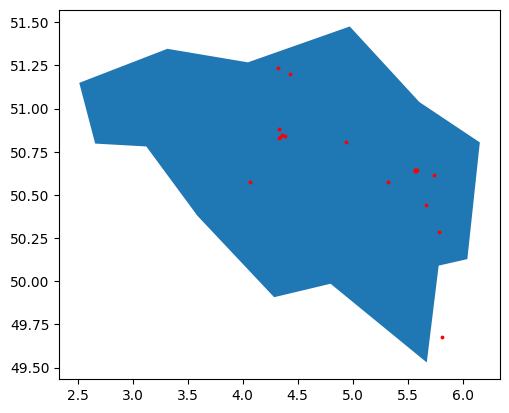

In [ ]:
# Filter the data to only include Belgium
belgium = world[world.name == "Belgium"]

# Plot the map of Belgium
ax = belgium.plot()

locations.plot(ax = ax, color='red', markersize=3)


In [ ]:
coordinates = locations.get_coordinates()

In [ ]:
type(coordinates)

pandas.core.frame.DataFrame

In [ ]:
df_aed['available'].value_counts()

available
Non-Nee                                                                              2508
Oui-Ja                                                                               1723
Oui                                                                                     9
N                                                                                       5
Ja                                                                                      3
Tijdens de kantooruren                                                                  2
Dispo. tout le temps sauf du samedi midi au dimanche 21h                                1
tijdens werkuren                                                                        1
enkel tijdens kantooruren                                                               1
zie rooster                                                                             1
Heures de bureau                                                                        1


In [ ]:
df_aed['province'].value_counts()

province
Antwerpen            2214
Bruxelles-Brussel    2042
Hainaut              1924
Liège                1748
Oost-Vlaanderen      1521
West-Vlaanderen      1312
Vlaams-Brabant       1230
Limburg               971
Namur                 882
Luxembourg            674
Brabant Wallon        672
Name: count, dtype: int64

In [ ]:
df_ambloc.head()

,base,medical_resource,province,region,departure_location,departure_location_number,latitude,longitude,occasional_permanence
0,BA ANTW [Borgerhout] AMBUCE,ZW ANTWERPEN 7 (Team: AAANTW07A),Antwerpen,Vlaams Gewest,Gijselstraat 150 2140 BORGERHOUT,3811,51.215516,4.443788,N
1,BA ANTW [Hoboken] AMBUCE,ZW ANTWERPEN 9 (Team: AAANTW09A),Antwerpen,Vlaams Gewest,Antwerpsesteenweg 242 2660 HOBOKEN,3812,51.178831,4.361948,N
2,BA ANTW [Hof Ter Schelde] AC Antwerpen,ZW ANTWERPEN 3 (Team: AAANTW03A),Antwerpen,Vlaams Gewest,August Vermeylenlaan 6 2050 ANTWERPEN,10902,51.232810,4.377237,N
3,BA ANTW [Kaai 606] SIHWA,ZW ANTWERPEN HAVEN 1 (Team: AAAPOR01A)_x000D_Z...,Antwerpen,Vlaams Gewest,Antwerpsebaan 4 (Kaai 606) 2040 ANTWERPEN,12902,51.315516,4.321506,N
4,BA ANTW [Sint Elisabeth] AC Antwerpen,ZW ANTWERPEN 2 (Team: AAANTW02A),Antwerpen,Vlaams Gewest,Leopoldstraat 26 2000 ANTWERPEN,10901,51.213623,4.405718,N


In [ ]:
df_intbxl2.head()

,Mission ID,T0,Cityname Intervention,Longitude intervention,Latitude intervention,description_nl,ic_description_nl,EventType and EventLevel,creationtime,Number of transported persons,...,Housenumber destination hospital,Abandon reason NL,Abandon reason FR,T1,T2,T3,T4,T5,T6,T7
0,20221520003,01JUN22:00:02:45,1030 schaerbeek (schaerbeek),4.406731e+10,5.085516e+10,Nieuwe melding,Medisch,P033 N05 - TRAUMA,01JUN22:00:04:06,NaN,...,None,Weigering vervoer,Refus,01JUN22:00:04:22,01JUN22:00:15:56,01JUN22:00:15:59,None,None,01JUN22:00:38:06,01JUN22:00:43:54
1,20221520005,01JUN22:00:04:58,1030 schaerbeek (schaerbeek),4.368798e+10,5.086318e+10,Nieuwe melding,Medisch,P032 N05 - ALLERGISCHE REACTIE,01JUN22:00:07:54,1.0,...,None,None,None,01JUN22:00:08:00,01JUN22:00:10:03,01JUN22:00:19:43,01JUN22:00:19:49,01JUN22:00:24:25,01JUN22:01:59:18,01JUN22:01:59:19
2,20221520006,01JUN22:00:07:43,1081 koekelberg (koekelberg),4.332312e+10,5.085755e+10,Nieuwe melding,Medisch,P010 N01 - ADEMHALINGSMOEILIJKHEDEN,01JUN22:00:12:05,1.0,...,None,None,None,None,None,None,None,None,None,None
3,20221520006,01JUN22:00:07:43,1081 koekelberg (koekelberg),4.332312e+10,5.085755e+10,Nieuwe melding,Medisch,P010 N01 - ADEMHALINGSMOEILIJKHEDEN,01JUN22:00:11:50,NaN,...,None,None,None,None,None,None,None,None,None,None
4,20221520007,01JUN22:00:09:18,1030 schaerbeek (schaerbeek),4.383695e+10,5.085225e+10,Nieuwe melding,Medisch,P039 N05 - CARDIAAL PROBLEEM (ANDERE DAN PIJN ...,01JUN22:00:11:37,NaN,...,None,Weigering vervoer,Refus,01JUN22:00:12:05,01JUN22:00:13:03,01JUN22:00:20:29,None,None,01JUN22:00:34:11,01JUN22:00:55:36


In [ ]:
df_intbxl2.loc[df_intbxl2['description_nl'] =='Dubbele melding']

,Mission ID,T0,Cityname Intervention,Longitude intervention,Latitude intervention,description_nl,ic_description_nl,EventType and EventLevel,creationtime,Number of transported persons,...,Housenumber destination hospital,Abandon reason NL,Abandon reason FR,T1,T2,T3,T4,T5,T6,T7
27,20221520030,01JUN22:02:35:53,1030 schaarbeek (schaarbeek),4.363131e+10,5.085901e+10,Dubbele melding,Medisch,P020 N05 - INTOXICATIE ALCOHOL,01JUN22:02:24:53,NaN,...,None,Weigering vervoer,Refus,01JUN22:02:25:02,01JUN22:02:27:27,01JUN22:02:39:00,None,None,01JUN22:02:39:01,01JUN22:03:04:43
57,20221520058,01JUN22:07:09:33,1190 forest (forest),4.309722e+10,5.080595e+10,Dubbele melding,Medisch,P005 N03 - WONDE DOOR WAPEN,01JUN22:07:09:49,1.0,...,None,None,None,None,None,None,None,None,None,None
58,20221520058,01JUN22:07:09:33,1190 forest (forest),4.309722e+10,5.080595e+10,Dubbele melding,Medisch,P005 N03 - WONDE DOOR WAPEN,01JUN22:07:09:49,NaN,...,None,None,None,None,None,None,None,None,None,None
122,20221520135,01JUN22:10:34:14,1000 bruxelles (bruxelles),4.377133e+10,5.084678e+10,Dubbele melding,Medisch,P000 N01 ARCA DEA,01JUN22:10:33:01,1.0,...,None,None,None,01JUN22:10:33:10,01JUN22:10:34:29,01JUN22:10:38:32,01JUN22:11:04:02,01JUN22:11:09:11,01JUN22:11:21:51,01JUN22:11:33:22
123,20221520135,01JUN22:10:34:14,1000 bruxelles (bruxelles),4.377133e+10,5.084678e+10,Dubbele melding,Medisch,P000 N01 ARCA DEA,01JUN22:10:33:01,NaN,...,None,None,None,01JUN22:10:33:11,01JUN22:10:33:36,01JUN22:10:41:57,01JUN22:11:04:16,01JUN22:11:08:46,01JUN22:11:21:51,01JUN22:11:45:04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38505,20222495101,06SEP22:10:04:15,1140 evere (evere),4.397553e+10,5.087139e+10,Dubbele melding,Medisch,P033 N05 - TRAUMA,06SEP22:10:08:37,NaN,...,None,None,None,None,None,None,None,None,None,None
38507,20222495101,06SEP22:10:04:15,1140 evere (evere),4.397553e+10,5.087139e+10,Dubbele melding,Medisch,P033 N05 - TRAUMA,06SEP22:09:50:35,1.0,...,None,None,None,06SEP22:09:50:54,06SEP22:09:52:41,06SEP22:09:56:18,06SEP22:10:56:35,06SEP22:10:58:48,06SEP22:11:23:51,06SEP22:11:27:14
38516,20222495111,06SEP22:10:14:52,1120 brussel (neder-over-heembeek),4.384104e+07,5.088983e+08,Dubbele melding,Medisch,None,None,NaN,...,None,None,None,None,None,None,None,None,None,None
38517,20222495111,06SEP22:10:14:52,1120 brussel (neder-over-heembeek),4.384104e+07,5.088983e+08,Dubbele melding,Medisch,None,None,NaN,...,None,None,None,None,None,None,None,None,None,None


In [ ]:
df_intbxl2.loc[df_intbxl2['Mission ID']== 20221520030]

,Mission ID,T0,Cityname Intervention,Longitude intervention,Latitude intervention,description_nl,ic_description_nl,EventType and EventLevel,creationtime,Number of transported persons,...,Housenumber destination hospital,Abandon reason NL,Abandon reason FR,T1,T2,T3,T4,T5,T6,T7
26,20221520030,01JUN22:02:23:44,1030 schaerbeek (schaerbeek),4.366199e+09,5.085849e+10,Nieuwe melding,Medisch,P020 N05 - INTOXICATIE ALCOHOL,01JUN22:02:24:53,NaN,...,None,Weigering vervoer,Refus,01JUN22:02:25:02,01JUN22:02:27:27,01JUN22:02:39:00,None,None,01JUN22:02:39:01,01JUN22:03:04:43
27,20221520030,01JUN22:02:35:53,1030 schaarbeek (schaarbeek),4.363131e+10,5.085901e+10,Dubbele melding,Medisch,P020 N05 - INTOXICATIE ALCOHOL,01JUN22:02:24:53,NaN,...,None,Weigering vervoer,Refus,01JUN22:02:25:02,01JUN22:02:27:27,01JUN22:02:39:00,None,None,01JUN22:02:39:01,01JUN22:03:04:43


In [ ]:
df_intbxl2['description_nl'].value_counts()

description_nl
Nieuwe melding     37394
Dubbele melding     1213
Oproep Politie         1
Algemene info          1
Name: count, dtype: int64